<a href="https://colab.research.google.com/github/R-Madhuram/DartmouthCapstone_CrudeOilPricePrediction/blob/main/notebooks/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [ ]:
#import libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style='whitegrid')
sns.set_context(context='paper',font_scale=1.5)
%matplotlib inline

#import utilities as util

#ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from statsmodels.tsa.stattools import adfuller
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa import arima_process


from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.linear_model import LinearRegression, ElasticNet,Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error
import io

import itertools


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# load data
us_cushing = pd.read_csv('/content/drive/MyDrive/PCDS_OilPricePrediction/data/USCushing.csv')
eu_brent = pd.read_csv('/content/drive/MyDrive/PCDS_OilPricePrediction/data/EuropeanBrent.csv')


## Cushing Data

In [ ]:
# Read data 
us_cushing.head().append(us_cushing.tail())

,Date,"Cushing, OK WTI Spot Price FOB (Dollars per Barrel)"
0,"Jan 02, 1986",25.56
1,"Jan 03, 1986",26.00
2,"Jan 06, 1986",26.53
3,"Jan 07, 1986",25.85
4,"Jan 08, 1986",25.87
9357,"Feb 22, 2023",73.95
9358,"Feb 23, 2023",75.26
9359,"Feb 24, 2023",76.19
9360,"Feb 27, 2023",75.57
9361,NaN,NaN


In [ ]:
# Information about the data
us_cushing.info 

<bound method DataFrame.info of               Date  Cushing, OK WTI Spot Price FOB (Dollars per Barrel)
0     Jan 02, 1986                                              25.56  
1     Jan 03, 1986                                              26.00  
2     Jan 06, 1986                                              26.53  
3     Jan 07, 1986                                              25.85  
4     Jan 08, 1986                                              25.87  
...            ...                                                ...  
9357  Feb 22, 2023                                              73.95  
9358  Feb 23, 2023                                              75.26  
9359  Feb 24, 2023                                              76.19  
9360  Feb 27, 2023                                              75.57  
9361           NaN                                                NaN  

[9362 rows x 2 columns]>

In [ ]:
# Null values 
us_cushing.isna().sum()

Date                                                   1
Cushing, OK WTI Spot Price FOB (Dollars per Barrel)    1
dtype: int64

## Brent Data

In [ ]:
# Read data
eu_brent.head().append(eu_brent.tail())

,Date,Europe Brent Spot Price FOB (Dollars per Barrel)
0,"May 20, 1987",18.63
1,"May 21, 1987",18.45
2,"May 22, 1987",18.55
3,"May 25, 1987",18.60
4,"May 26, 1987",18.63
9077,"Feb 22, 2023",79.55
9078,"Feb 23, 2023",82.08
9079,"Feb 24, 2023",82.31
9080,"Feb 27, 2023",82.31
9081,NaN,NaN


In [ ]:
# Information about the data
eu_brent.info 

<bound method DataFrame.info of               Date  Europe Brent Spot Price FOB (Dollars per Barrel)
0     May 20, 1987                                             18.63
1     May 21, 1987                                             18.45
2     May 22, 1987                                             18.55
3     May 25, 1987                                             18.60
4     May 26, 1987                                             18.63
...            ...                                               ...
9077  Feb 22, 2023                                             79.55
9078  Feb 23, 2023                                             82.08
9079  Feb 24, 2023                                             82.31
9080  Feb 27, 2023                                             82.31
9081           NaN                                               NaN

[9082 rows x 2 columns]>

In [ ]:
# Null values 
eu_brent.isna().sum()

Date                                                1
Europe Brent Spot Price FOB (Dollars per Barrel)    1
dtype: int64

# Creating dataframe with date as index and changing date as date-time object

## Cushing Data

In [ ]:
# Convert the date to dateimte object 
us_cushing['Date'] = pd.to_datetime(us_cushing['Date'], format = '%b %d, %Y')

In [ ]:
print(us_cushing['Date'].dtype)

datetime64[ns]


In [ ]:
# rename price column
us_cushing.rename(columns={'Cushing, OK WTI Spot Price FOB (Dollars per Barrel)':'price'},inplace=True)

In [ ]:
cushing_df = us_cushing

In [ ]:
cushing_df

,Date,price
0,1986-01-02,25.56
1,1986-01-03,26.00
2,1986-01-06,26.53
3,1986-01-07,25.85
4,1986-01-08,25.87
...,...,...
9357,2023-02-22,73.95
9358,2023-02-23,75.26
9359,2023-02-24,76.19
9360,2023-02-27,75.57


In [ ]:
# Change the index of the Df as date index
# cushing_df.index = pd.date_range(start='01-02-1986', end='02-27-2023', freq='D')
cushing_df = cushing_df.set_index('Date')

In [ ]:
cushing_df

,price
Date,
1986-01-02,25.56
1986-01-03,26.00
1986-01-06,26.53
1986-01-07,25.85
1986-01-08,25.87
...,...
2023-02-22,73.95
2023-02-23,75.26
2023-02-24,76.19


## Brent Data

In [ ]:
# Convert the date to dateimte object 
eu_brent['Date'] = pd.to_datetime(eu_brent['Date'], format = '%b %d, %Y')

In [ ]:
print(eu_brent['Date'].dtype)

datetime64[ns]


In [ ]:
# rename price column
eu_brent.rename(columns={'Europe Brent Spot Price FOB (Dollars per Barrel)':'price'},inplace=True)
eu_brent

,Date,price
0,1987-05-20,18.63
1,1987-05-21,18.45
2,1987-05-22,18.55
3,1987-05-25,18.60
4,1987-05-26,18.63
...,...,...
9077,2023-02-22,79.55
9078,2023-02-23,82.08
9079,2023-02-24,82.31
9080,2023-02-27,82.31


In [ ]:
brent_df = eu_brent

In [ ]:
# Change the index of the Df as date index
# brent_df.index = pd.date_range(start='05-20-1987', end='02-27-2023', freq='D')
brent_df = brent_df.set_index('Date')

In [ ]:
brent_df

,price
Date,
1987-05-20,18.63
1987-05-21,18.45
1987-05-22,18.55
1987-05-25,18.60
1987-05-26,18.63
...,...
2023-02-22,79.55
2023-02-23,82.08
2023-02-24,82.31


# Visualization of Cushing and Brent Crude oil data as time series


## Cushing Data

### Time Series plot

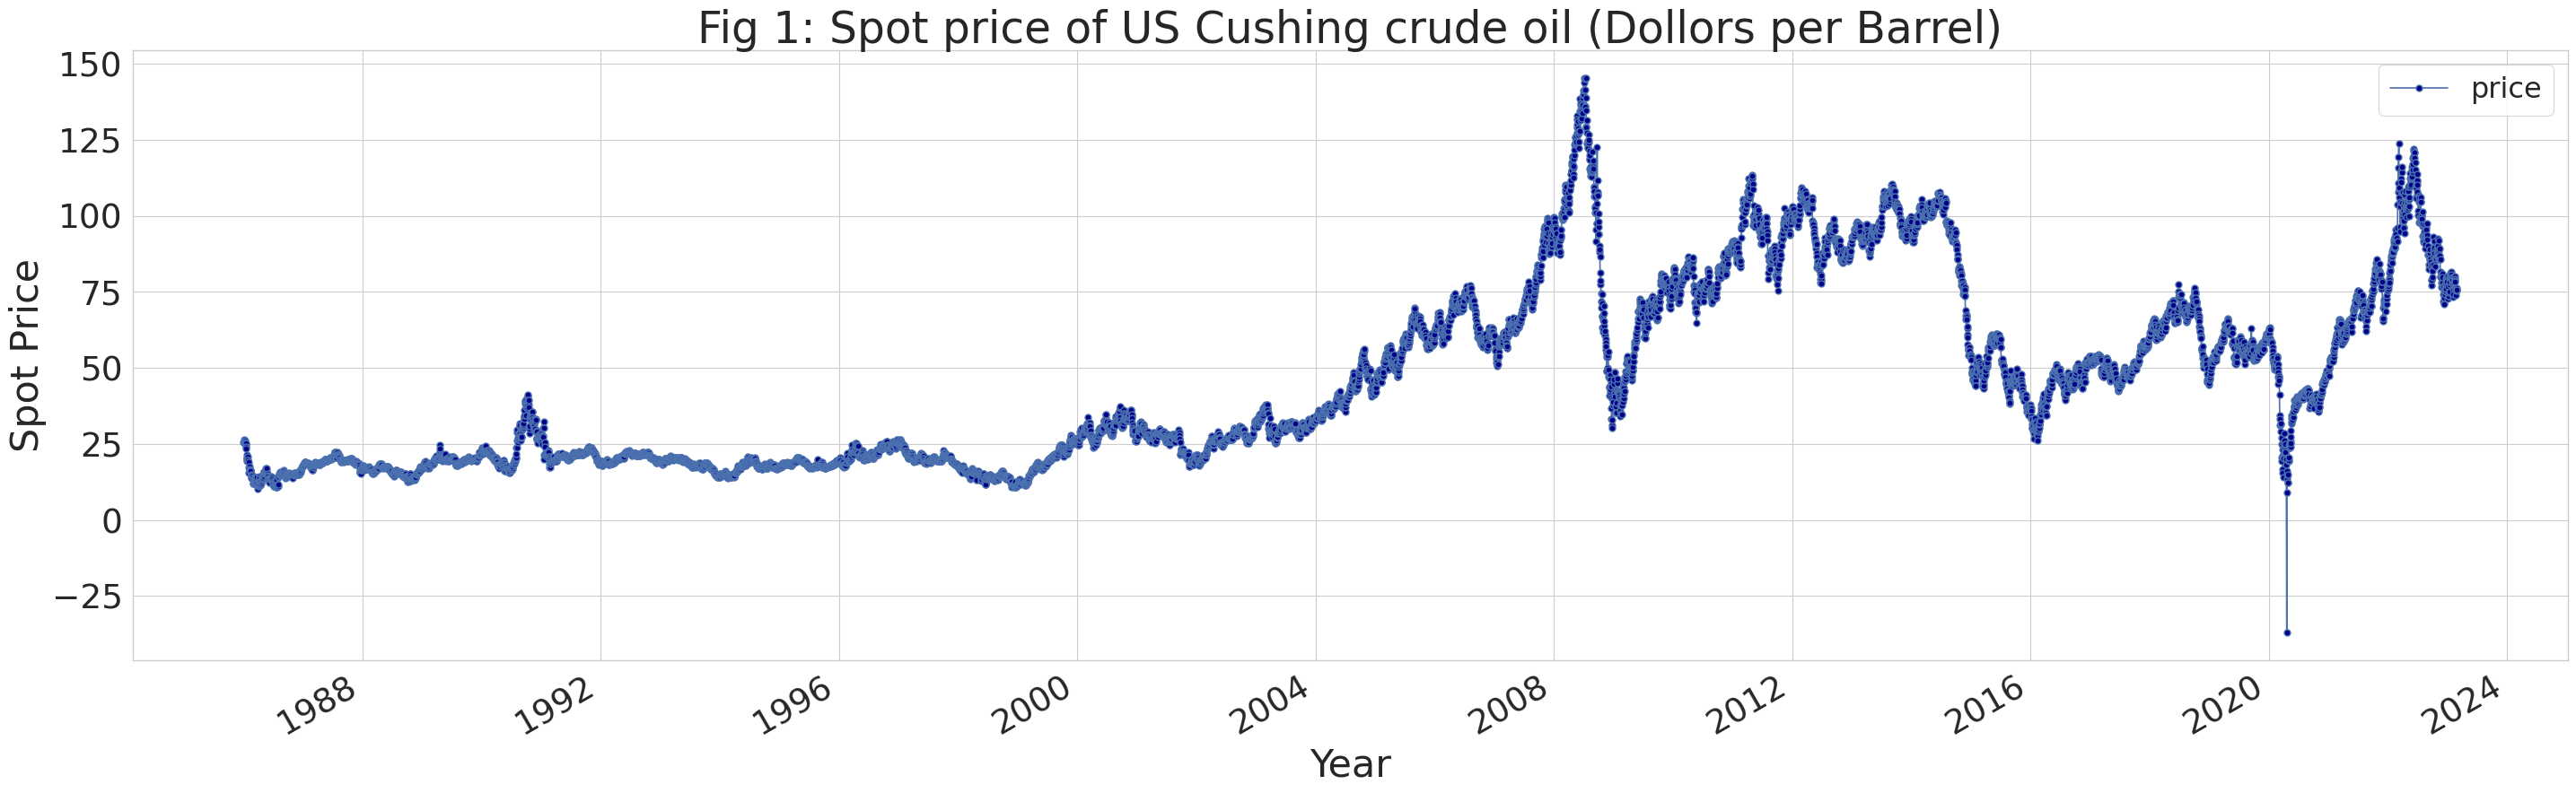

In [ ]:
# Time Series Plot of the Cushing data
fig_1 = cushing_df.squeeze().plot(figsize=(35,10),markersize=10, markerfacecolor= 'darkblue',marker='.',grid=True)
plt.legend(fontsize=23)
plt.title("Fig 1: Spot price of US Cushing crude oil (Dollors per Barrel)",fontsize=35)
plt.xlabel("Year", fontsize=31)
plt.ylabel("Spot Price",fontsize=31)
plt.xticks(fontsize=27)
plt.yticks(fontsize=27)
plt.savefig('fig_1_Cushing_ts.png')

### Histogram

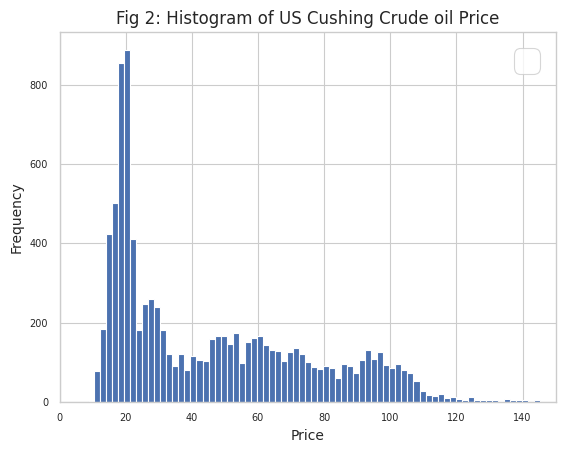

In [ ]:
# Histogram of Brent crude oil price
fig_2 = plt.hist(cushing_df['price'], bins=100)
plt.legend(fontsize=23)
plt.title("Fig 2: Histogram of US Cushing Crude oil Price",fontsize=12)
plt.xlabel("Price", fontsize=10)
plt.ylabel("Frequency",fontsize=10)
plt.xticks(fontsize=7)
plt.xlim([0,150])
plt.yticks(fontsize=7)
plt.savefig('fig_2_Cushing_histogram.png')



### Daily Percentage Change

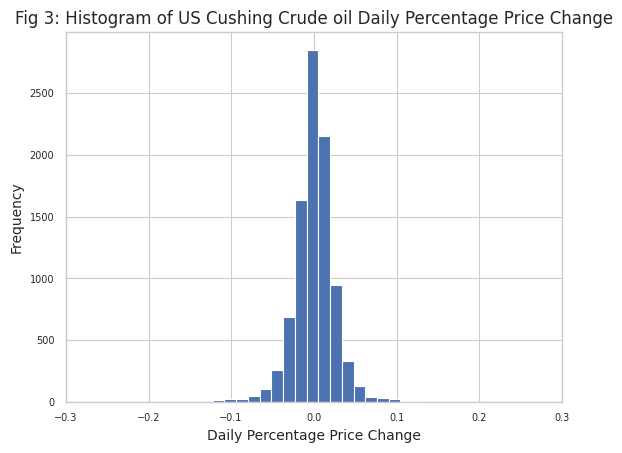

In [ ]:
# Percentage change in price per day for US Cushing Crude oil
pc_cushing = cushing_df['price'].pct_change()
fig_3 = pc_cushing.hist(bins=250)
plt.title("Fig 3: Histogram of US Cushing Crude oil Daily Percentage Price Change",fontsize=12)
plt.xlabel("Daily Percentage Price Change", fontsize=10)
plt.ylabel("Frequency",fontsize=10)
plt.xticks(fontsize=7)
plt.xlim([-0.3,0.3])
plt.yticks(fontsize=7)
plt.savefig('fig_3_Cushing_PC_histogram.png')


### 5% Daily Percentage Change

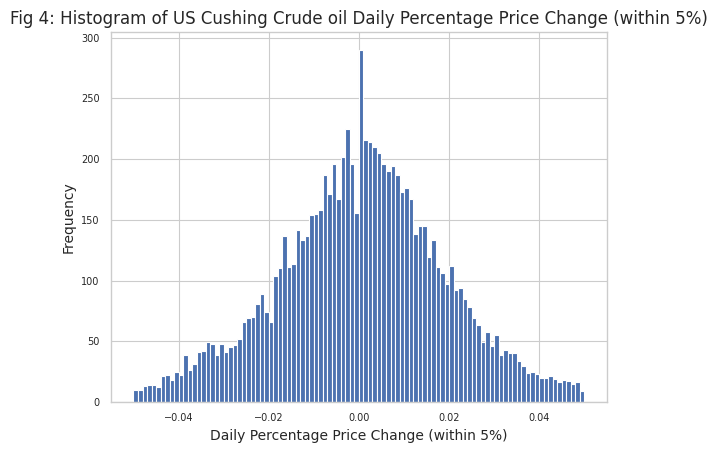

In [ ]:
# 5% Change in price per day for US Cushing Crude oil
fig_4 = plt.hist(pc_cushing, bins=100, range=(-0.05,0.05))
plt.title("Fig 4: Histogram of US Cushing Crude oil Daily Percentage Price Change (within 5%)",fontsize=12)
plt.xlabel("Daily Percentage Price Change (within 5%)", fontsize=10)
plt.ylabel("Frequency",fontsize=10)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.savefig('fig_4_Cushing_PC5_histogram.png')

## Brent Data

### Time Series plot

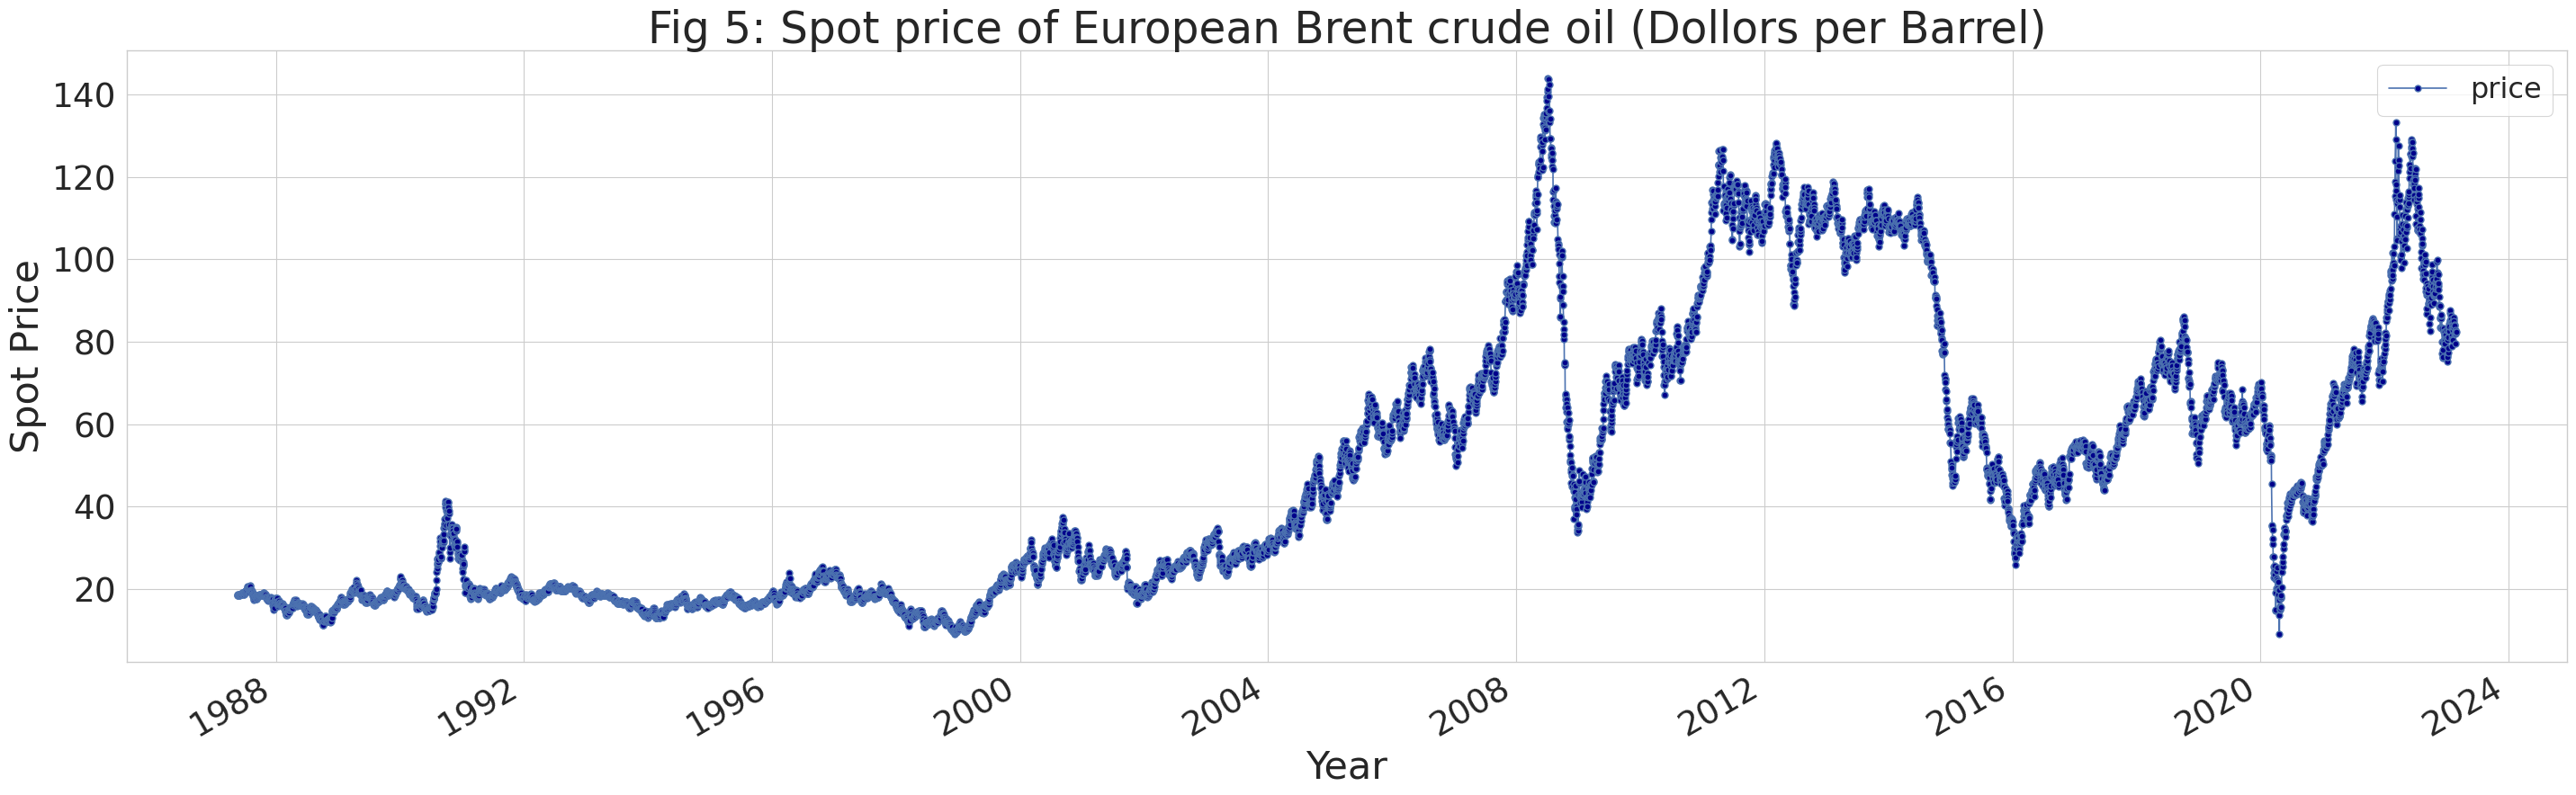

In [ ]:
# Time series plot Eropean Brent crude oil price data
fig_5 = brent_df.squeeze().plot(figsize=(35,10),markersize=10, markerfacecolor= 'darkblue',marker='.',grid=True)
plt.legend(fontsize=23)
plt.title("Fig 5: Spot price of European Brent crude oil (Dollors per Barrel)",fontsize=35)
plt.xlabel("Year", fontsize=31)
plt.ylabel("Spot Price",fontsize=31)
plt.xticks(fontsize=27)
plt.yticks(fontsize=27)
plt.savefig('fig_5_Brent_ts.png')

### Histogram

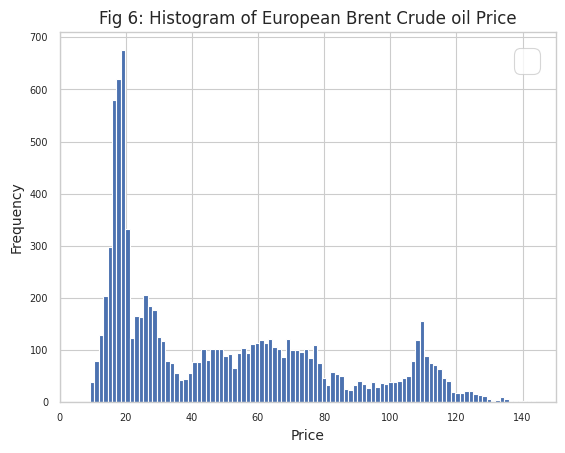

In [ ]:
# Histogram of European Brent crude oil price data
fig_6 = plt.hist(brent_df['price'], bins=100)
plt.legend(fontsize=23)
plt.title("Fig 6: Histogram of European Brent Crude oil Price",fontsize=12)
plt.xlabel("Price", fontsize=10)
plt.ylabel("Frequency",fontsize=10)
plt.xticks(fontsize=7)
plt.xlim([0,150])
plt.yticks(fontsize=7)
plt.savefig('fig_6_Brent_histogram.png')

### Daily Percentage Change

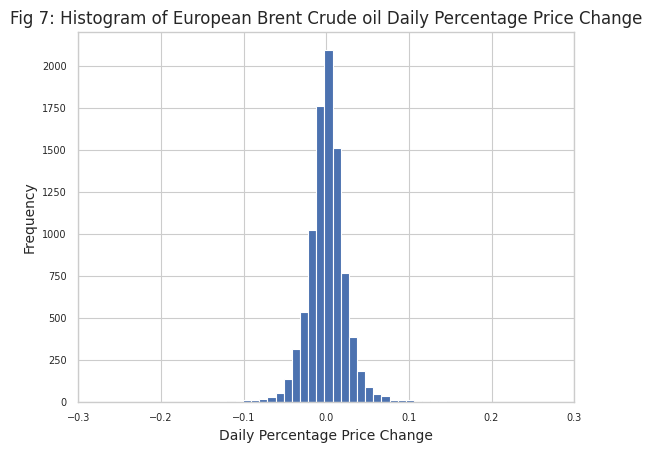

In [ ]:
# Percentage change in price per day for European Brent Crude oil
pc_brent = brent_df['price'].pct_change()
fig_7 = pc_brent.hist(bins=100)
plt.title("Fig 7: Histogram of European Brent Crude oil Daily Percentage Price Change",fontsize=12)
plt.xlabel("Daily Percentage Price Change", fontsize=10)
plt.ylabel("Frequency",fontsize=10)
plt.xticks(fontsize=7)
plt.xlim([-0.3,0.3])
plt.yticks(fontsize=7)
plt.savefig('fig_7_Brent_PC_histogram.png')


### 5% Daily Percentage Change

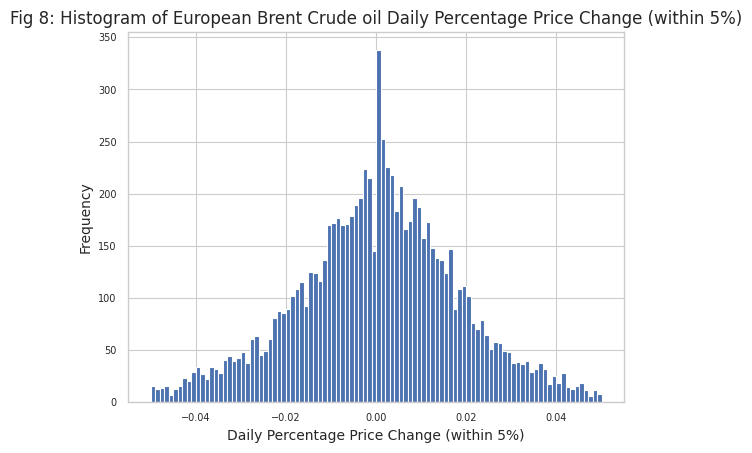

In [ ]:
# 5% Change in price per day for European Brent Crude oil
fig_8 = plt.hist(pc_brent, bins=100, range=(-0.05,0.05))
plt.title("Fig 8: Histogram of European Brent Crude oil Daily Percentage Price Change (within 5%)",fontsize=12)
plt.xlabel("Daily Percentage Price Change (within 5%)", fontsize=10)
plt.ylabel("Frequency",fontsize=10)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.savefig('fig_8_Brent_PC5_histogram.png')

# Percentages of Extreme and Normal Condition(s) of Daily Precent Price Changes

## Cushing Data

In [ ]:
# Percentages of data of daily price changes between 1%, 3% and 5% for US Cushing crude Oil price data

print("The percentage of price changes between 1%% and -1%% is %1.2f%%" % (100 * pc_cushing[(pc_cushing>-0.01) & (pc_cushing<0.01)].shape[0] / pc_cushing.shape[0]))
print("The percentage of price changes between 3%% and -3%% is %1.2f%%" % (100 * pc_cushing[(pc_cushing>-0.03) & (pc_cushing<0.03)].shape[0] / pc_cushing.shape[0]))
print("The percentage of price changes between 5%% and -5%% is %1.2f%%" % (100 * pc_cushing[(pc_cushing>-0.05) & (pc_cushing<0.05)].shape[0] / pc_cushing.shape[0]))
print("The percentage of price changes above 5%% increase is %1.2f%%" % (100*pc_cushing[(pc_cushing>0.05)].shape[0] / pc_cushing.shape[0]))
print("The percentage of price changes below 5%% decrease is %1.2f%%" % (100*pc_cushing[(pc_cushing<-0.05)].shape[0] / pc_cushing.shape[0]))


The percentage of price changes between 1% and -1% is 41.53%
The percentage of price changes between 3% and -3% is 83.45%
The percentage of price changes between 5% and -5% is 94.86%
The percentage of price changes above 5% increase is 2.51%
The percentage of price changes below 5% decrease is 2.62%


## Brent Data

In [ ]:
# Percentages of data of daily price changes between 1%, 3% and 5% for European Brent crude Oil price data

print("The percentage of price changes between 1%% and -1%% is %1.2f%%" % (100 * pc_brent[(pc_brent>-0.01) & (pc_brent<0.01)].shape[0] / pc_brent.shape[0]))
print("The percentage of price changes between 3%% and -3%% is %1.2f%%" % (100 * pc_brent[(pc_brent>-0.03) & (pc_brent<0.03)].shape[0] / pc_brent.shape[0]))
print("The percentage of price changes between 5%% and -5%% is %1.2f%%" % (100 * pc_brent[(pc_brent>-0.05) & (pc_brent<0.05)].shape[0] / pc_brent.shape[0]))
print("The percentage of price changes above 5%% increase is %1.2f%%" % (100*pc_brent[(pc_brent>0.05)].shape[0] / pc_brent.shape[0]))
print("The percentage of price changes below 5%% decrease is %1.2f%%" % (100*pc_brent[(pc_brent<-0.05)].shape[0] / pc_brent.shape[0]))

The percentage of price changes between 1% and -1% is 43.88%
The percentage of price changes between 3% and -3% is 85.47%
The percentage of price changes between 5% and -5% is 96.10%
The percentage of price changes above 5% increase is 2.13%
The percentage of price changes below 5% decrease is 1.76%


# Maximum and Minimum Daily Precent Price Changes

## Cushing Data

In [ ]:
# Maximum and Minimum values of daily percentage change of price of US Cushing crude oil
pc_cushing.max(), pc_cushing.idxmax(), pc_cushing.min(), pc_cushing.idxmin()

(0.5308641975308643,
 Timestamp('2020-04-22 00:00:00'),
 -3.0196613872200984,
 Timestamp('2020-04-20 00:00:00'))

In [ ]:
cushing_df.iloc[[]]

,price
Date,


In [ ]:
cushing_df.iloc[[]]

,price
Date,


## Brent Data

In [ ]:
# Maximum and Minimum values of daily percentage change of price of European Brent crude oil
pc_brent.max(), pc_brent.idxmax(), pc_brent.min(), pc_brent.idxmin()

(0.5098684210526316,
 Timestamp('2020-04-22 00:00:00'),
 -0.4746543778801844,
 Timestamp('2020-04-21 00:00:00'))

In [ ]:
brent_df.iloc[[]]

,price
Date,


In [ ]:
brent_df.iloc[[]]

,price
Date,


# Calculation of weekly, monthly and yearly averages of crude oil price

## Cushing Data

### Adding years, weeks, months, and days of the week column to the dataframe

In [ ]:
# Make a copy of the original dataframe cushing_df
cushing_dt = cushing_df.copy(deep=True)

In [ ]:
# Adding days, week, months and year columns to the dataframe
cushing_dt['dayofweek'] = cushing_dt.index.dayofweek
cushing_dt['week_no'] = cushing_dt.index.week
cushing_dt['month_no'] = cushing_dt.index.month
cushing_dt['year'] = cushing_dt.index.year

In [ ]:
cushing_dt.head().append(cushing_dt.tail())

,price,dayofweek,week_no,month_no,year
Date,,,,,
1986-01-02,25.56,3.0,1.0,1.0,1986.0
1986-01-03,26.00,4.0,1.0,1.0,1986.0
1986-01-06,26.53,0.0,2.0,1.0,1986.0
1986-01-07,25.85,1.0,2.0,1.0,1986.0
1986-01-08,25.87,2.0,2.0,1.0,1986.0
2023-02-22,73.95,2.0,8.0,2.0,2023.0
2023-02-23,75.26,3.0,8.0,2.0,2023.0
2023-02-24,76.19,4.0,8.0,2.0,2023.0
2023-02-27,75.57,0.0,9.0,2.0,2023.0


### Grouping by weeks to determine weekly average

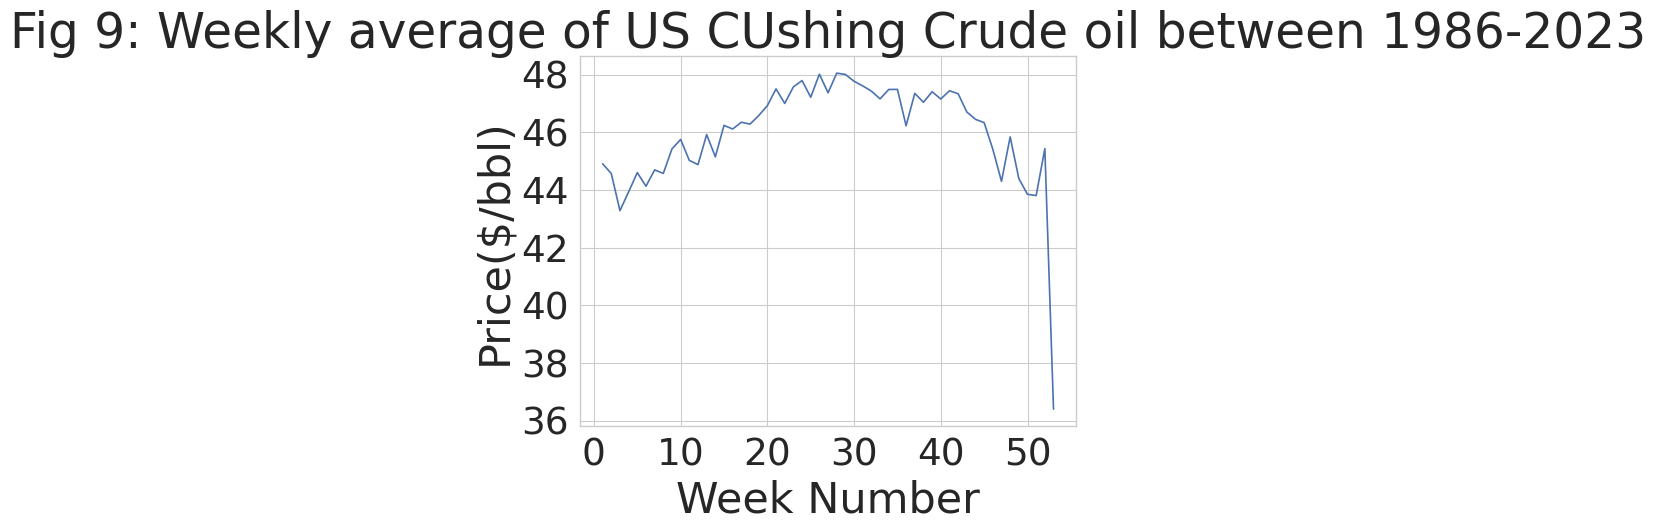

In [ ]:
# Grouping by weeks and plotting the mean
fig_9 = plt.plot(cushing_dt.groupby('week_no')['price'].mean())
plt.title("Fig 9: Weekly average of US CUshing Crude oil between 1986-2023",fontsize=35)
plt.xlabel("Week Number", fontsize=31)
plt.ylabel("Price($/bbl)",fontsize=31)
plt.xticks(fontsize=27)
plt.yticks(fontsize=27)
plt.savefig('fig_9_Cushing_WeeklyAverage.png')


In [ ]:
# Pivot table by weeks and extracting the weekly mean values 
cushing_weekly = cushing_dt.pivot_table(values='price', columns=['year'], aggfunc=np.mean, 
                                        index= ['week_no'])
cushing_weekly.head()

year,1986.0,1987.0,1988.0,1989.0,1990.0,1991.0,1992.0,1993.0,1994.0,1995.0,...,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0,2020.0,2021.0,2022.0,2023.0
week_no,,,,,,,,,,,,,,,,,,,,,
1.0,20.974,18.130,17.604,17.345,24.330,22.960,19.325,19.002,15.034,17.615,...,69.9700,52.7200,34.6480,53.3425,61.3625,52.758,62.0850,50.0940,77.8580,74.2675
2.0,25.986,18.376,16.794,18.060,22.622,27.546,18.412,18.620,14.666,17.552,...,92.4160,48.7740,30.5860,52.0660,63.2560,50.780,60.8400,52.7520,81.5160,77.0960
3.0,24.568,19.042,17.196,19.048,22.712,26.852,18.810,18.608,15.024,18.448,...,92.9760,47.0660,29.1925,51.8225,63.7700,51.924,58.2880,52.8275,85.9275,80.3400
4.0,20.314,18.676,16.924,17.854,23.076,24.080,18.656,19.898,15.340,18.338,...,96.1875,46.4575,31.8080,52.7420,65.1380,52.875,56.1525,52.5240,86.9400,80.3260
5.0,19.692,18.616,17.076,17.410,22.704,21.414,19.048,20.220,15.762,18.496,...,97.2900,45.3260,31.2600,53.3280,65.3180,53.634,52.6960,55.3960,89.5960,76.5060


### Grouping by Months to determine monthly average

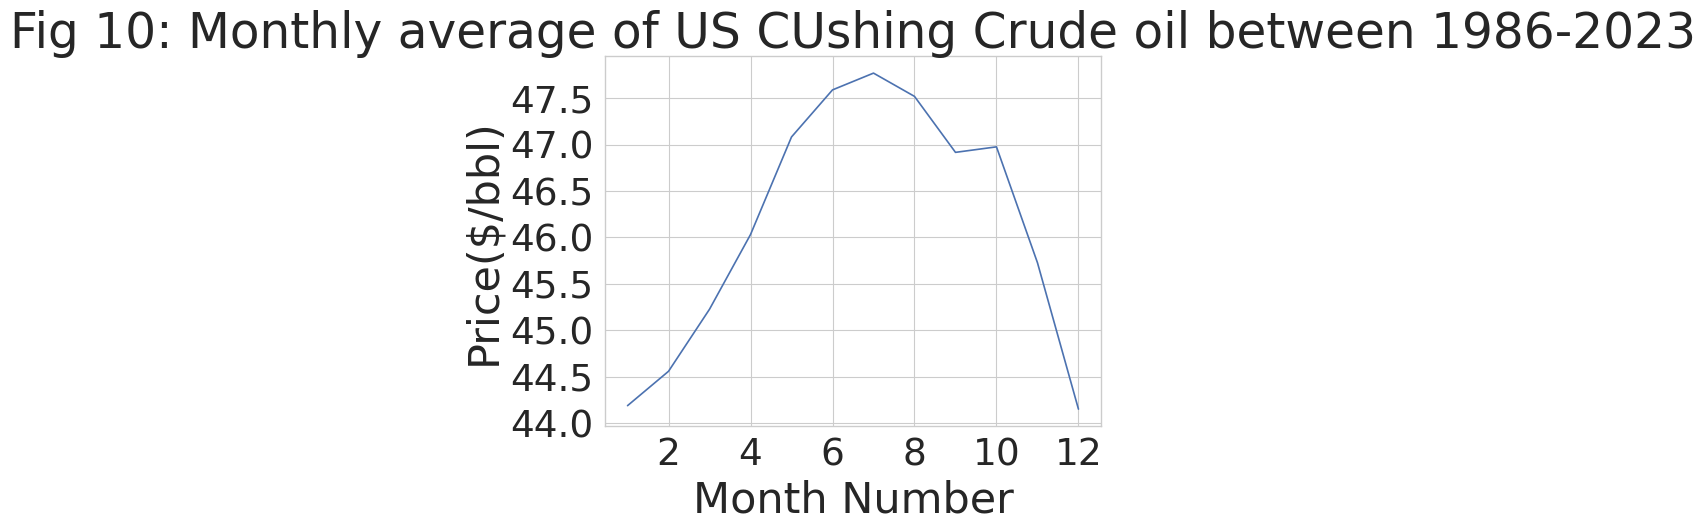

In [ ]:
# Grouping by months and plotting the mean
fig_10 = plt.plot(cushing_dt.groupby('month_no')['price'].mean())
plt.title("Fig 10: Monthly average of US CUshing Crude oil between 1986-2023",fontsize=35)
plt.xlabel("Month Number", fontsize=31)
plt.ylabel("Price($/bbl)",fontsize=31)
plt.xticks(fontsize=27)
plt.yticks(fontsize=27)
plt.savefig('fig_10_Cushing_MonthlyAverage.png')

In [ ]:
# Pivot table by months and extracting the monthly mean values 
cushing_monthly = cushing_dt.pivot_table(values='price', columns=['year'], aggfunc=np.mean, 
                                        index= ['month_no'])
cushing_monthly.head()

year,1986.0,1987.0,1988.0,1989.0,1990.0,1991.0,1992.0,1993.0,1994.0,1995.0,...,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0,2020.0,2021.0,2022.0,2023.0
month_no,,,,,,,,,,,,,,,,,,,,,
1.0,22.925455,18.651429,17.129500,18.024286,22.863182,25.234091,18.785455,19.032000,15.026667,18.039524,...,94.617143,47.219000,31.683158,52.504000,63.698571,51.375714,57.519048,52.008421,83.222000,78.123
2.0,15.454737,17.748947,16.795714,17.936500,22.113000,20.477500,19.012500,20.086111,14.781053,18.570000,...,100.817368,50.584211,30.323000,53.468421,62.229474,54.954737,50.542632,59.046316,91.641053,76.830
3.0,12.612500,18.302857,16.197391,19.484091,20.387727,19.901500,18.921818,20.322174,14.680870,18.539130,...,100.803810,47.823636,37.546364,49.327826,62.724762,58.151429,29.207727,62.333043,108.502609,NaN
4.0,12.843636,18.677143,17.862500,21.069000,18.425500,20.830000,20.230000,20.252500,16.420000,19.896316,...,102.069048,54.452857,40.755238,51.060526,66.253810,63.862381,16.547619,61.716667,101.777500,NaN
5.0,15.377619,19.437500,17.423636,20.123478,18.199545,21.232273,20.975500,19.949500,17.889048,19.741818,...,102.177143,59.265000,46.712381,48.476364,69.978182,60.826818,28.562500,65.169500,109.552381,NaN


### Grouping by Years to determine yearly average

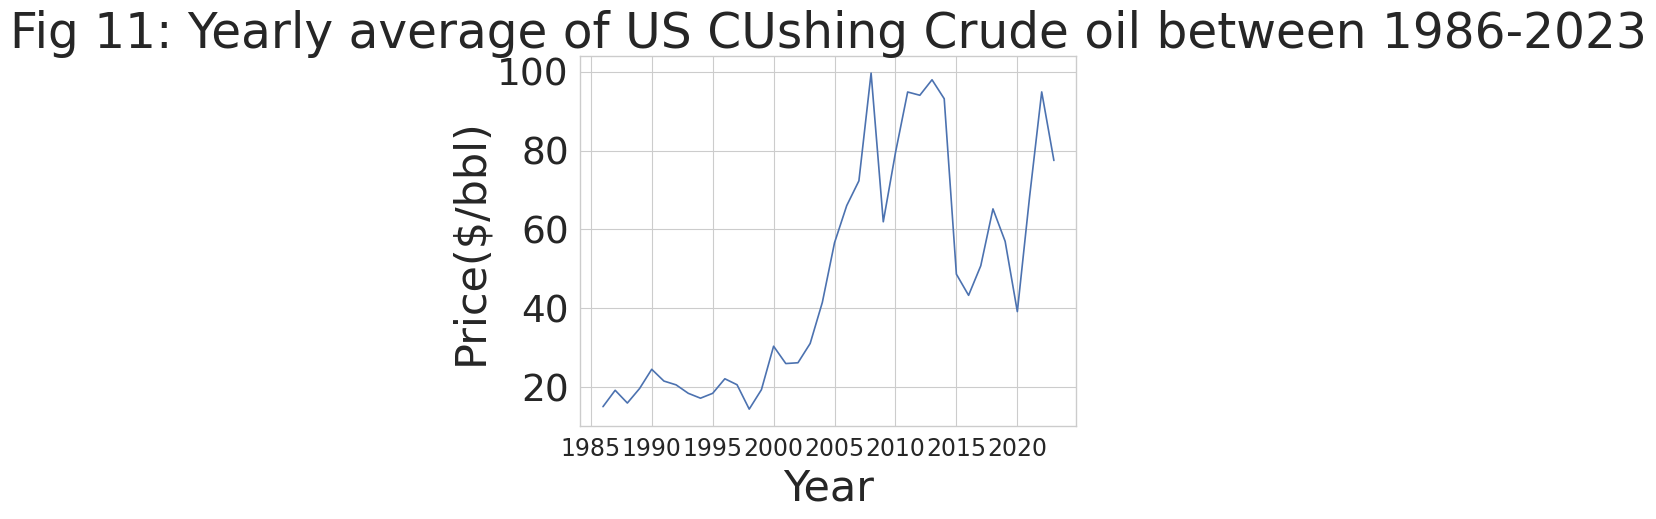

In [ ]:
# Grouping by months and plotting the mean
fig_11 = plt.plot(cushing_dt.groupby('year')['price'].mean())
plt.title("Fig 11: Yearly average of US CUshing Crude oil between 1986-2023",fontsize=35)
plt.xlabel("Year", fontsize=31)
plt.ylabel("Price($/bbl)",fontsize=31)
plt.xticks(fontsize=17)
plt.yticks(fontsize=27)
plt.savefig('fig_11_Cushing_YearlyAverage.png')

In [ ]:
# Pivot table by Years and extracting the yearly mean values 
cushing_yearly = cushing_dt.pivot_table(values='price', columns=['year'], aggfunc=np.mean, 
                                        )
cushing_yearly.head()

year,1986.0,1987.0,1988.0,1989.0,1990.0,1991.0,1992.0,1993.0,1994.0,1995.0,...,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0,2020.0,2021.0,2022.0,2023.0
price,15.047689,19.200512,15.965409,19.635486,24.526576,21.541367,20.575564,18.4322,17.196429,18.428805,...,93.172222,48.656706,43.293651,50.80032,65.22747,56.98832,39.160437,68.1351,94.902869,77.510526


## Brent Data

### Adding years, weeks, months, and days of the week column to the dataframe

In [ ]:
# Make a copy of the original dataframe brent_df
brent_dt = brent_df.copy(deep=True)

In [ ]:
# Adding days, week, months and year columns to the dataframe
brent_dt['dayofweek'] = brent_dt.index.dayofweek
brent_dt['week_no'] = brent_dt.index.week
brent_dt['month_no'] = brent_dt.index.month
brent_dt['year'] = brent_dt.index.year

In [ ]:
brent_dt.head().append(brent_dt.tail())

,price,dayofweek,week_no,month_no,year
Date,,,,,
1987-05-20,18.63,2.0,21.0,5.0,1987.0
1987-05-21,18.45,3.0,21.0,5.0,1987.0
1987-05-22,18.55,4.0,21.0,5.0,1987.0
1987-05-25,18.60,0.0,22.0,5.0,1987.0
1987-05-26,18.63,1.0,22.0,5.0,1987.0
2023-02-22,79.55,2.0,8.0,2.0,2023.0
2023-02-23,82.08,3.0,8.0,2.0,2023.0
2023-02-24,82.31,4.0,8.0,2.0,2023.0
2023-02-27,82.31,0.0,9.0,2.0,2023.0


### Grouping by weeks to determine weekly average

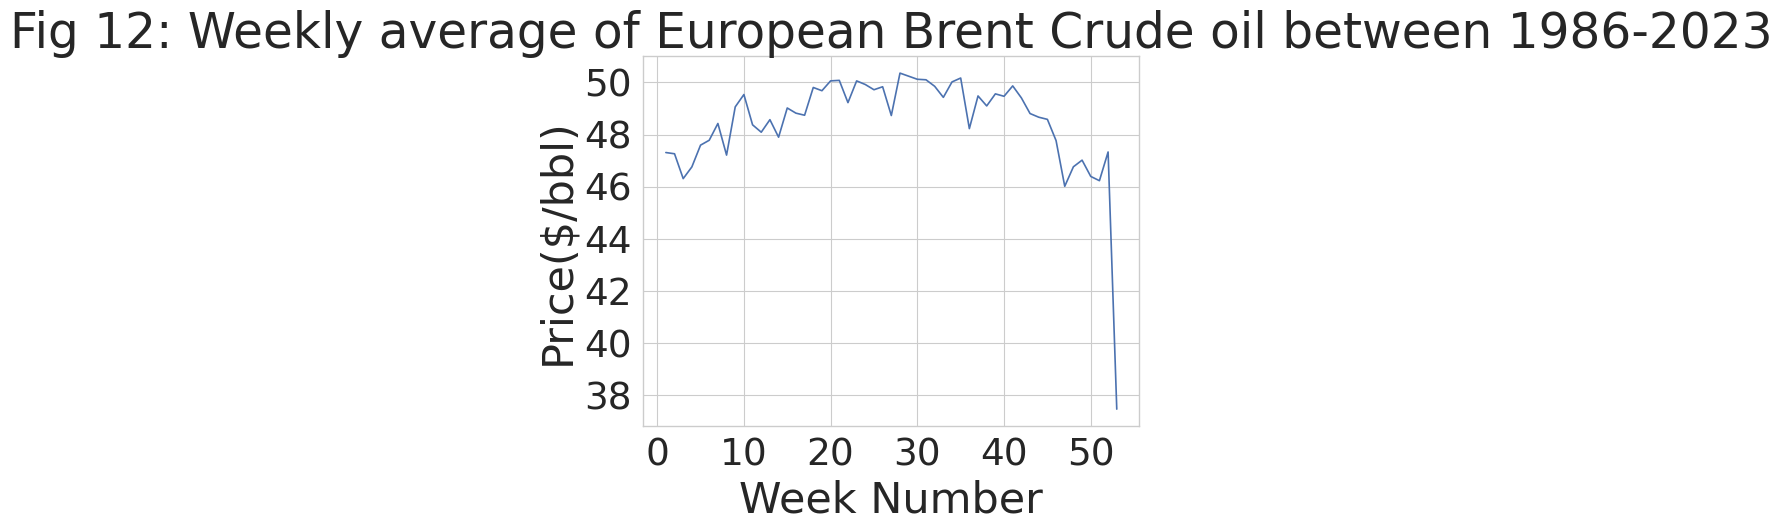

In [ ]:
# Grouping by weeks and plotting the mean
fig_12 = plt.plot(brent_dt.groupby('week_no')['price'].mean())
plt.title("Fig 12: Weekly average of European Brent Crude oil between 1986-2023",fontsize=35)
plt.xlabel("Week Number", fontsize=31)
plt.ylabel("Price($/bbl)",fontsize=31)
plt.xticks(fontsize=27)
plt.yticks(fontsize=27)
plt.savefig('fig_12_Brent_WeeklyAverage.png')


In [ ]:
# Pivot table by weeks and extracting the weekly mean values 
brent_weekly = brent_dt.pivot_table(values='price', columns=['year'], aggfunc=np.mean, 
                                        index= ['week_no'])
brent_weekly.head()

year,1987.0,1988.0,1989.0,1990.0,1991.0,1992.0,1993.0,1994.0,1995.0,1996.0,...,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0,2020.0,2021.0,2022.0,2023.0
week_no,,,,,,,,,,,,,,,,,,,,,
1.0,NaN,17.4525,16.590,23.566,22.332,18.475,17.510,14.1775,16.0725,20.763333,...,76.648,55.3800,34.194,55.1275,67.810,59.800,68.065,53.308,80.502,77.2025
2.0,NaN,16.4360,16.980,21.674,25.328,17.772,17.052,14.0000,16.2320,18.528000,...,107.014,49.4660,29.100,54.0160,69.470,58.636,67.930,55.380,85.068,80.6060
3.0,NaN,16.9080,17.896,21.052,25.856,18.370,16.978,14.2160,16.8840,17.614000,...,107.828,46.5780,27.756,54.1940,69.388,59.830,64.112,55.230,89.158,84.5700
4.0,NaN,16.2400,17.328,20.494,20.766,18.112,18.004,14.6420,16.8480,17.188000,...,109.140,46.4425,31.748,54.9060,70.040,61.342,62.200,55.178,90.124,85.9040
5.0,NaN,16.1420,16.666,20.654,20.720,18.276,18.575,15.1340,16.9860,16.644000,...,108.834,46.7640,32.184,55.5340,68.004,61.380,58.572,58.222,92.774,81.8700


### Grouping by Months to determine monthly average

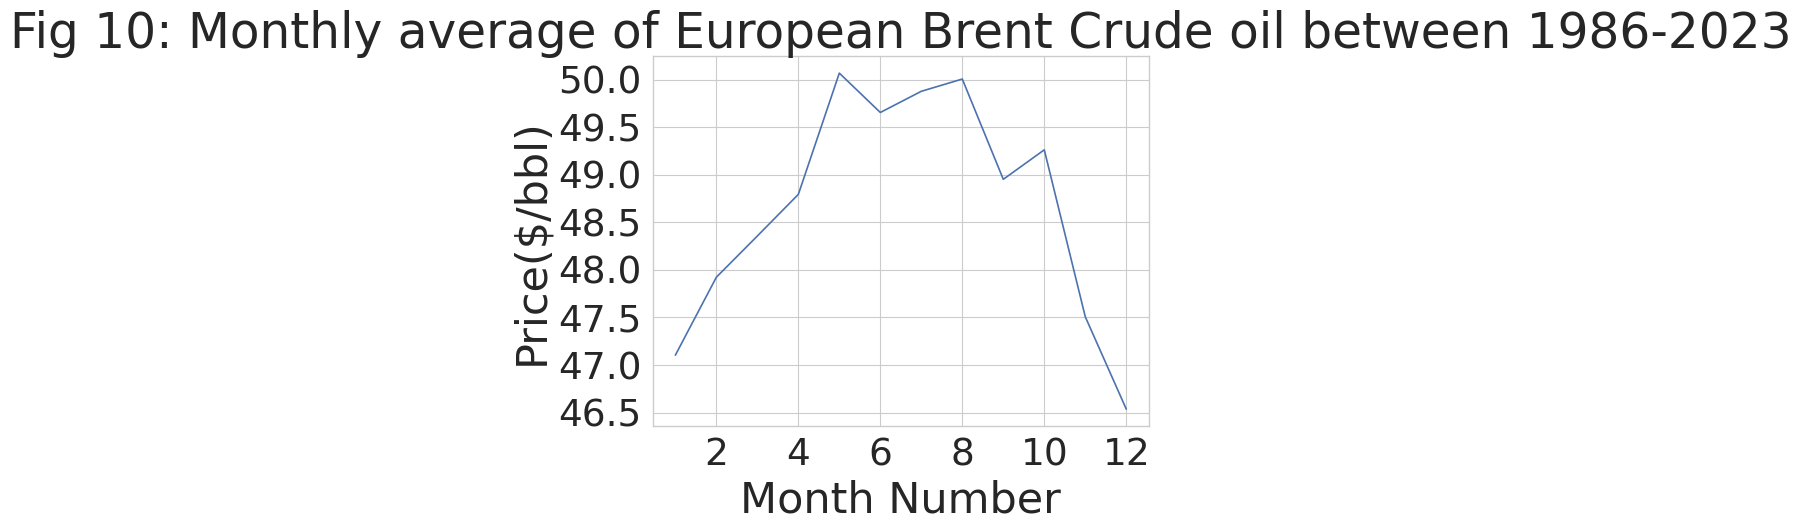

In [ ]:
# Grouping by months and plotting the mean
fig_13 = plt.plot(brent_dt.groupby('month_no')['price'].mean())
plt.title("Fig 10: Monthly average of European Brent Crude oil between 1986-2023",fontsize=35)
plt.xlabel("Month Number", fontsize=31)
plt.ylabel("Price($/bbl)",fontsize=31)
plt.xticks(fontsize=27)
plt.yticks(fontsize=27)
plt.savefig('fig_13_Brent_MonthlyAverage.png')

In [ ]:
# Pivot table by months and extracting the monthly mean values 
brent_monthly = brent_dt.pivot_table(values='price', columns=['year'], aggfunc=np.mean, 
                                        index= ['month_no'])
brent_monthly.head()

year,1987.0,1988.0,1989.0,1990.0,1991.0,1992.0,1993.0,1994.0,1995.0,1996.0,...,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0,2020.0,2021.0,2022.0,2023.0
month_no,,,,,,,,,,,,,,,,,,,,,
1.0,NaN,16.749444,17.171905,21.251818,23.566364,18.163636,17.386000,14.291500,16.551905,17.853182,...,108.117727,47.759500,30.699500,54.576667,69.077273,59.409545,63.645455,54.774000,86.505238,82.501429
2.0,NaN,15.729524,16.888500,19.813500,19.536000,18.053500,18.466316,13.802000,17.114500,17.999048,...,108.900526,58.095500,32.181500,54.869500,65.317500,63.960500,55.657000,62.276500,97.129000,82.608421
3.0,NaN,14.731304,18.700952,18.387273,19.082500,17.630909,18.785217,13.822609,17.006522,19.851905,...,107.480952,55.885455,38.210455,51.589130,66.016667,66.138571,32.011364,65.410000,117.245217,NaN
4.0,NaN,16.595263,20.319500,16.612105,19.180000,18.919048,18.674500,15.231579,18.648333,20.900500,...,107.755238,59.524286,41.583333,52.307895,72.106000,71.233333,18.378500,64.806500,104.575263,NaN
5.0,18.58,16.314091,18.633182,16.352273,19.186818,19.888500,18.507895,16.188000,18.350909,19.154762,...,109.539091,64.075000,46.742381,50.326522,76.975238,71.317727,29.378947,68.534211,113.337619,NaN


### Grouping by Years to determine yearly average

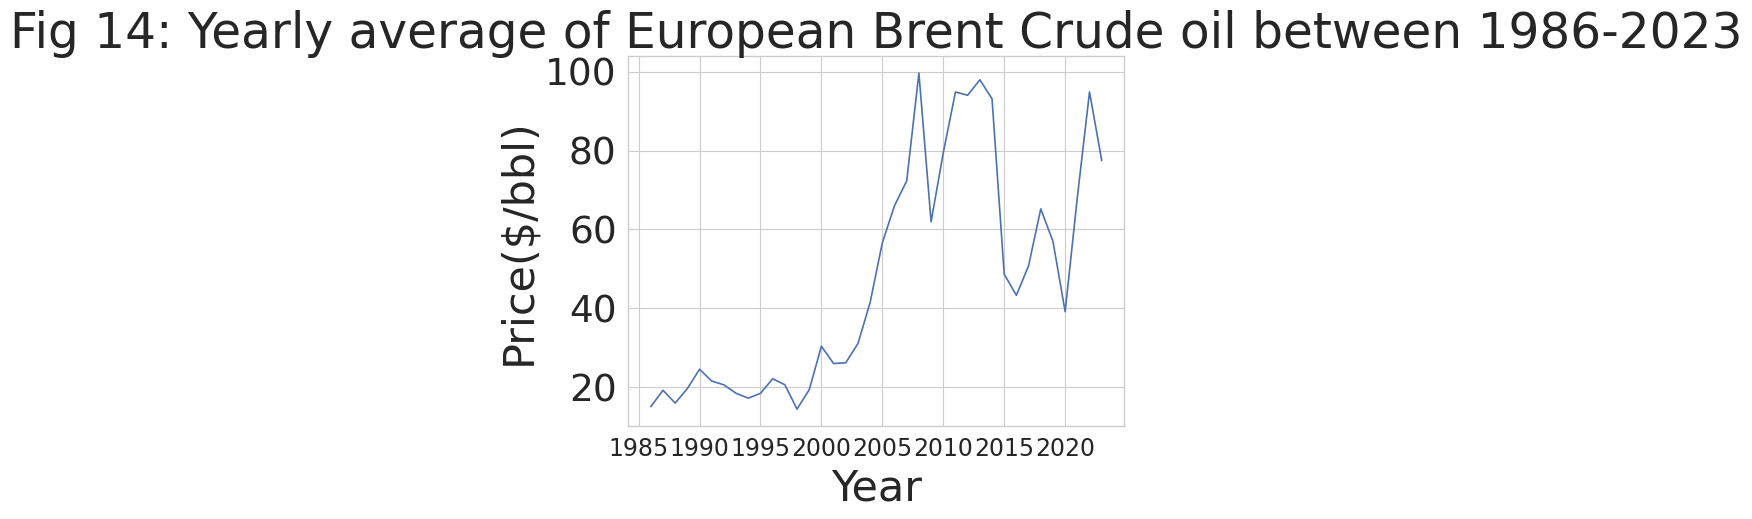

In [ ]:
# Grouping by months and plotting the mean
fig_14 = plt.plot(cushing_dt.groupby('year')['price'].mean())
plt.title("Fig 14: Yearly average of European Brent Crude oil between 1986-2023",fontsize=35)
plt.xlabel("Year", fontsize=31)
plt.ylabel("Price($/bbl)",fontsize=31)
plt.xticks(fontsize=17)
plt.yticks(fontsize=27)
plt.savefig('fig_14_Brent_YearlyAverage.png')

In [ ]:
# Pivot table by Years and extracting the yearly mean values 
brent_yearly = brent_dt.pivot_table(values='price', columns=['year'], aggfunc=np.mean, 
                                        )
brent_yearly.head()

year,1987.0,1988.0,1989.0,1990.0,1991.0,1992.0,1993.0,1994.0,1995.0,1996.0,...,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0,2020.0,2021.0,2022.0,2023.0
price,18.525813,14.905412,18.228228,23.761445,20.041128,19.319728,17.013413,15.856389,17.01585,20.639803,...,98.969606,52.316549,43.638,54.124805,71.335,64.300623,41.957255,70.855336,100.93131,82.55225


# RESULTS



*   We have plotted the price data series as a function of time this notebook to obtain the time series of botht he crude oil prices. 

*   Upon visualizing the various distribution plots of both Bren and CUshing price and price changes percentage daily and within 5%, we observe that they have very similar patterns. 

 •       We observe that the general pattern of the price distributions including the frequency of various price ranges, daily percentage change in price and daily percentage change in price within 5% for both EU Brent and US Cushing crude oil exhibit significant similarity.
•       For instance, the most frequent price of both EU Brent and US Cushing is ~ 20 dollors/bbl of crude oil. 

•       However, the number of observations withing the most frequent price varies between the two types of crude oil with EU Brent consisting of nearly 250 more sample within that range than US Cushing. This could also be due to the difference in number bins between the visualizations of EU Brent and US Cushing data. 

•       Also, EU Brent crude oil daily price change distribution implies that it is just as likely as US Cushing crude oil to not show/show daily fluctuations price 

•       A similar pattern is observed when daily price chage percentage is limited to 5% between both the crude.



*   We also performed aggregation operation to see any pattern associated with time and found that the price of crude oil increases during the middle of the ans lowere during the year end.





